# DepthAI - Hello World

This notebook will read and display frames from the rgb camera and a simple neural network.

In [1]:
# first, import all necessary modules
from pathlib import Path
import blobconverter
import cv2
import depthai
import numpy as np

In [2]:
# these modules will enable us to build a simple event driven UI in the Jupyter notebook
import ipywidgets as widgets
import threading
from IPython.display import display, Image

In [3]:
# Pipeline tells DepthAI what operations to perform when running - you define all of the resources used and flows here
pipeline = depthai.Pipeline()
assert pipeline is not None

In [4]:
# First, we want the Color camera as the output
cam_rgb = pipeline.createColorCamera()
cam_rgb.setPreviewSize(300, 300)  # 300x300 will be the preview frame size, available as 'preview' output of the node
cam_rgb.setInterleaved(False)

In [5]:
# Next, we want a neural network that will produce the detections
detection_nn = pipeline.createMobileNetDetectionNetwork()
# Blob is the Neural Network file, compiled for MyriadX. It contains both the definition and weights of the model
# We're using a blobconverter tool to retreive the MobileNetSSD blob automatically from OpenVINO Model Zoo
detection_nn.setBlobPath(blobconverter.from_zoo(name='mobilenet-ssd', shaves=6))
# Next, we filter out the detections that are below a confidence threshold. Confidence can be anywhere between <0..1>
detection_nn.setConfidenceThreshold(0.5)
# Next, we link the camera 'preview' output to the neural network detection input, so that it can produce detections
cam_rgb.preview.link(detection_nn.input)

In [6]:
# XLinkOut is a "way out" from the device. Any data you want to transfer to host need to be send via XLink
xout_rgb = pipeline.createXLinkOut()
# For the rgb camera output, we want the XLink stream to be named "rgb"
xout_rgb.setStreamName("rgb")
# Linking camera preview to XLink input, so that the frames will be sent to host
cam_rgb.preview.link(xout_rgb.input)

# The same XLinkOut mechanism will be used to receive nn results
xout_nn = pipeline.createXLinkOut()
xout_nn.setStreamName("nn")
detection_nn.out.link(xout_nn.input)

In [7]:
def showVideo(button):

    # Pipeline is now finished, and we need to find an available device to run our pipeline
    # we are using context manager here that will dispose the device after we stop using it
    with depthai.Device(pipeline) as device:
        # From this point, the Device will be in "running" mode and will start sending data via XLink

        # To consume the device results, we get two output queues from the device, with stream names we assigned earlier
        q_rgb = device.getOutputQueue("rgb")
        q_nn = device.getOutputQueue("nn")

        # Here, some of the default values are defined. Frame will be an image from "rgb" stream, detections will contain nn results
        frame = None
        detections = []

        # Since the detections returned by nn have values from <0..1> range, they need to be multiplied by frame width/height to
        # receive the actual position of the bounding box on the image
        def frameNorm(frame, bbox):
            normVals = np.full(len(bbox), frame.shape[0])
            normVals[::2] = frame.shape[1]
            return (np.clip(np.array(bbox), 0, 1) * normVals).astype(int)


        # Main host-side application loop
        while True:
            # we try to fetch the data from nn/rgb queues. tryGet will return either the data packet or None if there isn't any
            in_rgb = q_rgb.tryGet()
            in_nn = q_nn.tryGet()

            if in_rgb is not None:
                # If the packet from RGB camera is present, we're retrieving the frame in OpenCV format using getCvFrame
                frame = in_rgb.getCvFrame()

            if in_nn is not None:
                # when data from nn is received, we take the detections array that contains mobilenet-ssd results
                detections = in_nn.detections

            if frame is not None:
                for detection in detections:
                    # for each bounding box, we first normalize it to match the frame size
                    bbox = frameNorm(frame, (detection.xmin, detection.ymin, detection.xmax, detection.ymax))
                    # and then draw a rectangle on the frame to show the actual result
                    cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)

                # convert the frame from a OpenCV numpy array to a jpeg 
                # so that we can display it in the Jupyter notebook.
                _, jpg = cv2.imencode('.jpeg', frame)
                
                # show the frame on the screen.
                display_handle.update(Image(data=jpg.tobytes()))
                if stopButton.value==True:
                    break                 
               

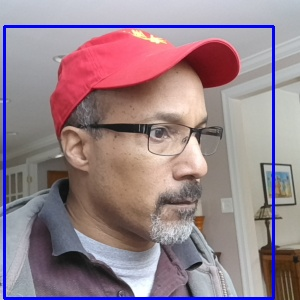

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Stop the Video')

In [8]:
# define the button widget
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger',
    tooltip='Stop the Video',
    icon='square'
)

# initialize the display window
display_handle=display(None, display_id=True)
# display the stop button
display(stopButton)
# create a thread that calls the showVideo() function above
thread = threading.Thread(target=showVideo, args=(stopButton,))
thread.start()